# Finetuned LegalBench

In [1]:
import pandas as pd
import json
import re
import matplotlib.pyplot as plt
import seaborn as sns

Get Actual LegalBench classification dataset with parsed column

In [2]:
input_dir = '../datasets/llm_outputs/legalbench_classification'

fp_actual = f'{input_dir}/2024_coherent_legalbench_classification.csv'
df_actual = pd.read_csv(fp_actual)

In [4]:
def parse_classification(raw_resp):
    regex = r'"classification":\s*"([^"]+)"'
    match = re.search(regex, raw_resp)
    if match:
        return match.group(1)
    else:
        return None

In [6]:
df_actual['legalbench'] = df_actual['legalbench_classification_raw'].apply(parse_classification)
df_actual.head()

,transcript_id,question_addressee,justice,question_text,opening_statement,full_text,label,legalbench_classification_raw,legalbench
0,2024.23-621-t01,petitioner,Clarence Thomas,But I thought your argument hinged on a court...,<speaker>Erika L. Maley</speaker><text> Mr. Ch...,"<speaker>John G. Roberts, Jr.</speaker><text> ...",coherent,"{\n""classification"": ""Clarification"",\n""reason...",Clarification
1,2024.23-621-t01,petitioner,Elena Kagan,"Well, it's -- it's true that it's only a lik...",<speaker>Erika L. Maley</speaker><text> Mr. Ch...,"<speaker>John G. Roberts, Jr.</speaker><text> ...",coherent,"{\n""classification"": ""Criticism"",\n""reasoning""...",Criticism
2,2024.23-621-t01,petitioner,Ketanji Brown Jackson,But it's not that determination that's making...,<speaker>Erika L. Maley</speaker><text> Mr. Ch...,"<speaker>John G. Roberts, Jr.</speaker><text> ...",coherent,"{\n""classification"": ""Criticism"",\n""reasoning""...",Criticism
3,2024.23-621-t01,petitioner,Ketanji Brown Jackson,When you think about the difference between m...,<speaker>Erika L. Maley</speaker><text> Mr. Ch...,"<speaker>John G. Roberts, Jr.</speaker><text> ...",coherent,"{\n ""classification"": ""Clarification"",\n ""re...",Clarification
4,2024.23-621-t01,petitioner,Ketanji Brown Jackson,But didn't Sole open -- leave open that --th...,<speaker>Erika L. Maley</speaker><text> Mr. Ch...,"<speaker>John G. Roberts, Jr.</speaker><text> ...",coherent,"{\n""classification"": ""Criticism"",\n""reasoning""...",Criticism


Llama 8B

In [ ]:
dir = '/scratch/gpfs/nnadeem/llms-for-oral-arguments/finetune/outputs/OS_questions/processed/metrics'
base_fp = f'{dir}/llama_8B_base_inference_compiled_all_metrics.csv' ## File from Kylie, renamed
finetuned_fp = f'{dir}/dialogue_finetuned_8B_inference_compiled_all_metrics.csv'

In [8]:
df_base = pd.read_csv(base_fp)
df_ft = pd.read_csv(finetuned_fp)
df_ft = df_ft[df_ft['is_question']] ## Filter out non-question statements

**Standardize justice names across all 3 dataframes**:

In [9]:
def standardize_justice_names(df, col='justice'):
    mapping = {
        # Short names in df_base
        'jackson': 'Ketanji Brown Jackson',
        'thomas': 'Clarence Thomas',
        'alito': 'Samuel A. Alito, Jr.',
        'kagan': 'Elena Kagan',
        'kavanaugh': 'Brett M. Kavanaugh',
        'roberts': 'John G. Roberts, Jr.',
        'sotomayor': 'Sonia Sotomayor',
        'barrett': 'Amy Coney Barrett',
        'gorsuch': 'Neil Gorsuch',

        # Lowercase snake_case style in df_ft
        'justice_ketanji_brown_jackson': 'Ketanji Brown Jackson',
        'justice_clarence_thomas': 'Clarence Thomas',
        'justice_samuel_a_alito_jr': 'Samuel A. Alito, Jr.',
        'justice_elena_kagan': 'Elena Kagan',
        'justice_brett_m_kavanaugh': 'Brett M. Kavanaugh',
        'justice_john_g_roberts_jr': 'John G. Roberts, Jr.',
        'justice_sonia_sotomayor': 'Sonia Sotomayor',
        'justice_amy_coney_barrett': 'Amy Coney Barrett',
        'justice_neil_gorsuch': 'Neil Gorsuch',

        # Full names in df_actual (map to themselves)
        'Ketanji Brown Jackson': 'Ketanji Brown Jackson',
        'Clarence Thomas': 'Clarence Thomas',
        'Samuel A. Alito, Jr.': 'Samuel A. Alito, Jr.',
        'Elena Kagan': 'Elena Kagan',
        'Brett M. Kavanaugh': 'Brett M. Kavanaugh',
        'John G. Roberts, Jr.': 'John G. Roberts, Jr.',
        'Sonia Sotomayor': 'Sonia Sotomayor',
        'Amy Coney Barrett': 'Amy Coney Barrett',
        'Neil Gorsuch': 'Neil Gorsuch',
    }
    
    return df.copy().assign(**{col: df[col].map(mapping)})


In [10]:
df_base = standardize_justice_names(df_base)
df_ft = standardize_justice_names(df_ft)
df_actual = standardize_justice_names(df_actual)

In [11]:
df_base.head()

,Unnamed: 0,question_id,transcript_id,question_addressee,justice,opening_statement,question_text,full_text,valence,legalbench,metacog
0,0,q_8728fa1b,2024.23-621-t01,petitioner,Brett M. Kavanaugh,<speaker>Erika L. Maley</speaker><text> Mr. Ch...,You argue that a preliminary injunction does n...,"<speaker>John G. Roberts, Jr.</speaker><text> ...",Competitive,Implications,argumentation_and_clarification
1,1,q_5cb7b5c9,2024.23-621-t01,petitioner,Brett M. Kavanaugh,<speaker>Erika L. Maley</speaker><text> Mr. Ch...,How do you respond to the argument that the pu...,"<speaker>John G. Roberts, Jr.</speaker><text> ...",Competitive,Criticism,argumentation_and_clarification
2,2,q_c6bffd9f,2024.23-621-t01,petitioner,Brett M. Kavanaugh,<speaker>Erika L. Maley</speaker><text> Mr. Ch...,You cite to legal dictionaries from the time o...,"<speaker>John G. Roberts, Jr.</speaker><text> ...",Competitive,Criticism,statutory_interpretation
3,3,q_9b18b63e,2024.23-621-t01,petitioner,Brett M. Kavanaugh,<speaker>Erika L. Maley</speaker><text> Mr. Ch...,Your proposed bright-line rule would seem to c...,"<speaker>John G. Roberts, Jr.</speaker><text> ...",Competitive,Criticism,precedent_and_doctrine
4,4,q_34e89a7e,2024.23-365 -t01,petitioner,Brett M. Kavanaugh,<speaker>Lisa S. Blatt</speaker><text> Thank y...,"Counsel, you argue that RICO excludes damages ...","<speaker>John G. Roberts, Jr.</speaker><text> ...",Competitive,Clarification,statutory_interpretation


## Plots

In [12]:
# Select and rename relevant columns for merging
df_actual_legalbench = df_actual[['transcript_id', 'justice', 'legalbench']].copy()
df_actual_legalbench['source'] = 'Actual'

df_base_legalbench = df_base[['transcript_id', 'justice', 'legalbench']].copy()
df_base_legalbench['source'] = 'Base Llama-8B'

df_ft_legalbench = df_ft[['transcript_id', 'justice', 'legalbench']].copy()
df_ft_legalbench['source'] = 'Finetuned Llama-8B'

# Combine all datasets
combined_legalbench = pd.concat([df_actual_legalbench, df_base_legalbench, df_ft_legalbench], ignore_index=True)


In [13]:
combined_legalbench.head()

,transcript_id,justice,legalbench,source
0,2024.23-621-t01,Clarence Thomas,Clarification,Actual
1,2024.23-621-t01,Elena Kagan,Criticism,Actual
2,2024.23-621-t01,Ketanji Brown Jackson,Criticism,Actual
3,2024.23-621-t01,Ketanji Brown Jackson,Clarification,Actual
4,2024.23-621-t01,Ketanji Brown Jackson,Criticism,Actual


In [14]:
# Group by and count occurrences
combined_legalbench_proportions = (
    combined_legalbench.groupby(['justice', 'transcript_id', 'source', 'legalbench'])
    .size()
    .reset_index(name='count')
)

# Calculate proportions
combined_legalbench_proportions['proportion'] = combined_legalbench_proportions.groupby(
    ['justice', 'transcript_id', 'source']
)['count'].transform(lambda x: x / x.sum())

In [15]:
combined_legalbench_proportions.head()

,justice,transcript_id,source,legalbench,count,proportion
0,Amy Coney Barrett,2024.22-7466,Finetuned Llama-8B,Background,6,0.428571
1,Amy Coney Barrett,2024.22-7466,Finetuned Llama-8B,Clarification,8,0.571429
2,Amy Coney Barrett,2024.22-7466-t01,Actual,Background,1,0.333333
3,Amy Coney Barrett,2024.22-7466-t01,Actual,Clarification,2,0.666667
4,Amy Coney Barrett,2024.22-7466-t01,Base Llama-8B,Clarification,5,0.714286


### Plot Pie Charts

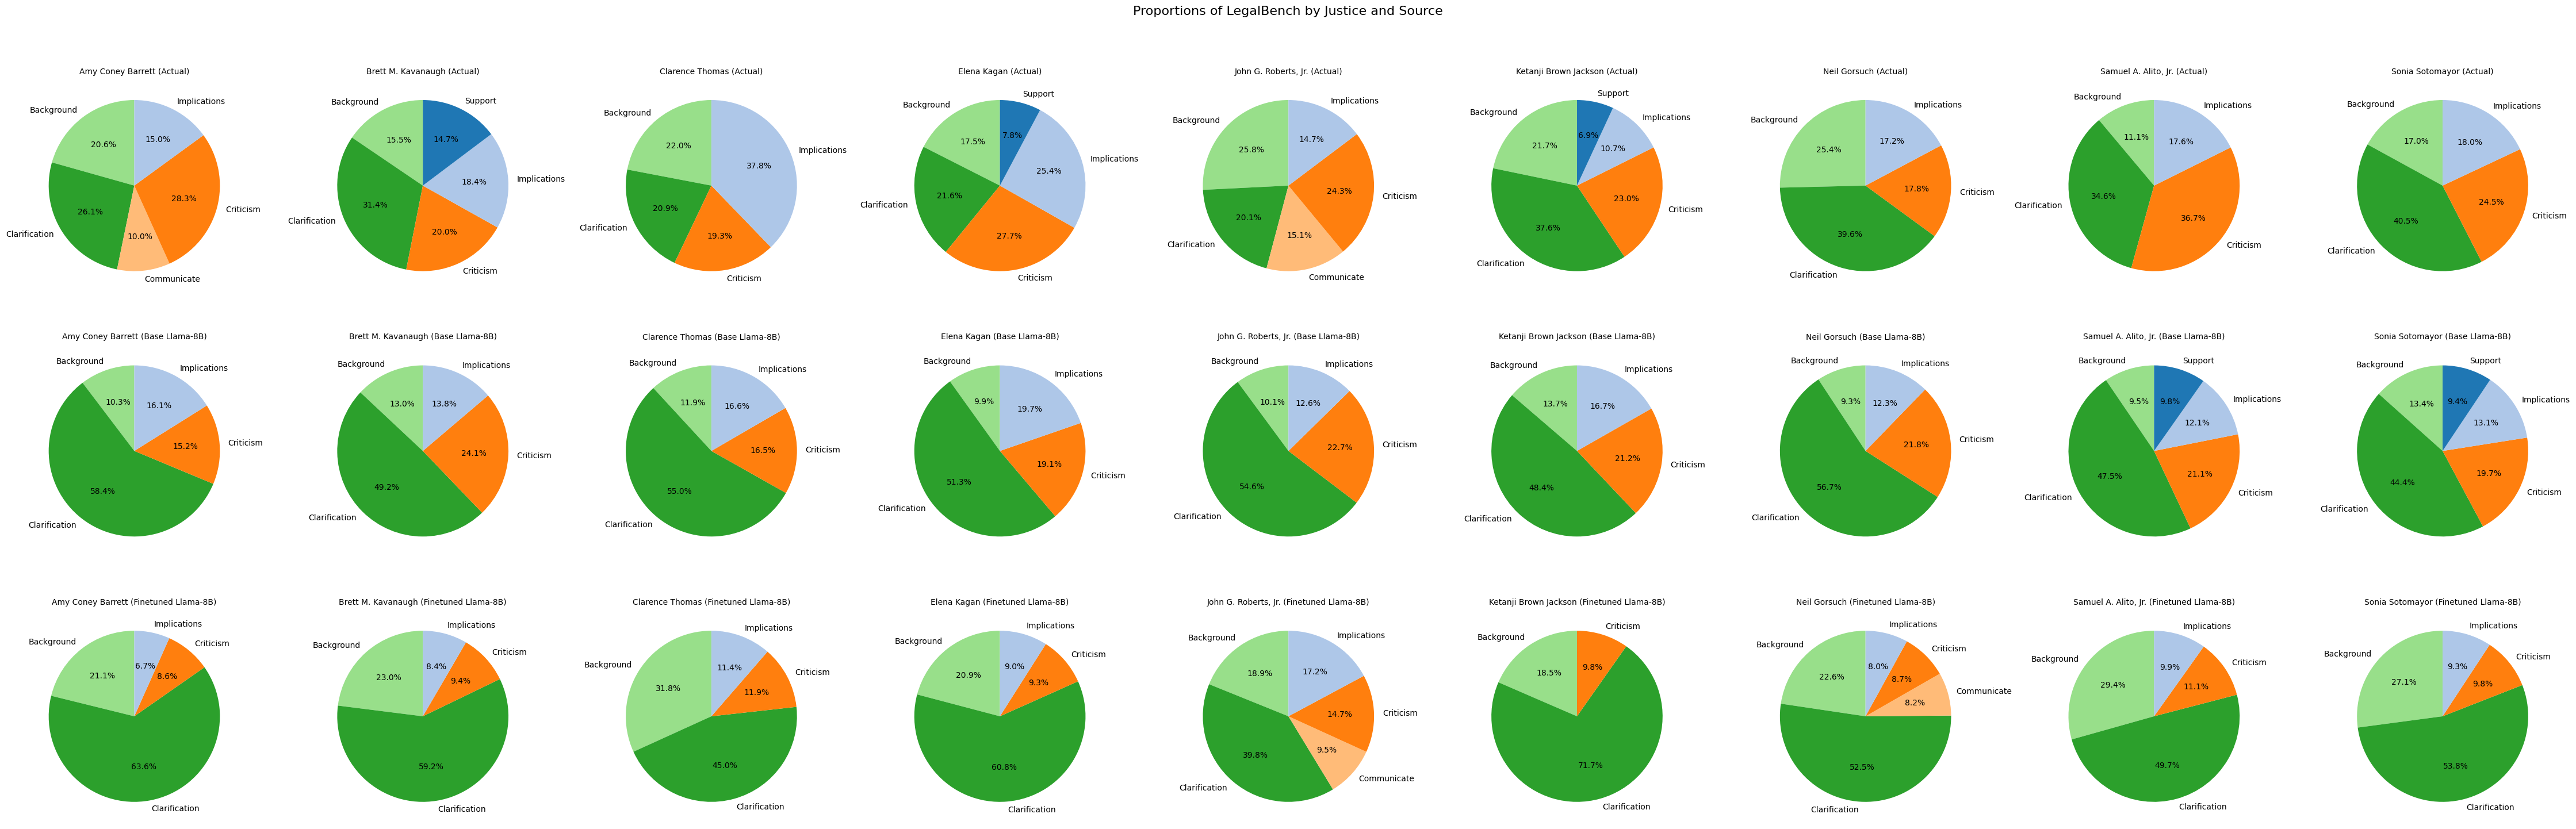

In [20]:
mean_proportions_pie = combined_legalbench_proportions.groupby(['source', 'justice', 'legalbench'])['proportion'].mean().reset_index()

# Reverse the legalbench categories for color mapping
legalbench_categories = mean_proportions_pie['legalbench'].unique()[::-1]
color_palette = plt.cm.tab20.colors[:len(legalbench_categories)]
color_map = dict(zip(legalbench_categories, color_palette))

sources = mean_proportions_pie['source'].unique()
justices = mean_proportions_pie['justice'].unique()

# Handle single row/column edge cases
n_rows = len(sources)
n_cols = len(justices)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows), subplot_kw={'aspect': 'equal'})

# Ensure axes is always 2D array-like for uniform indexing
if n_rows == 1 and n_cols == 1:
    axes = [[axes]]
elif n_rows == 1:
    axes = [axes]
elif n_cols == 1:
    axes = [[ax] for ax in axes]

for i, source in enumerate(sources):
    for j, justice in enumerate(justices):
        ax = axes[i][j]
        subset = mean_proportions_pie[
            (mean_proportions_pie['source'] == source) &
            (mean_proportions_pie['justice'] == justice)
        ]
        
        if not subset.empty:
            colors = [color_map[val] for val in subset['legalbench']]
            ax.pie(
                subset['proportion'],
                labels=subset['legalbench'],
                autopct='%1.1f%%',
                startangle=90,
                colors=colors
            )
            ax.set_title(f"{justice} ({source})", fontsize=10)
        else:
            ax.axis('off')

plt.suptitle('Proportions of LegalBench by Justice and Source', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [25]:
def plot_legalbench_pie_for_justice(df, justice_name):
    # Filter for the selected justice
    subset_df = df[df['justice'] == justice_name]
    
    if subset_df.empty:
        print(f"No data found for justice: {justice_name}")
        return

    # Reverse legalbench categories for consistent color mapping
    legalbench_categories = df['legalbench'].unique()[::-1]
    color_palette = plt.cm.tab20.colors[:len(legalbench_categories)]
    color_map = dict(zip(legalbench_categories, color_palette))

    sources = subset_df['source'].unique()

    fig, axes = plt.subplots(1, len(sources), figsize=(4.5 * len(sources), 4.5), subplot_kw={'aspect': 'equal'})

    # Make axes iterable even for one subplot
    if len(sources) == 1:
        axes = [axes]

    for i, source in enumerate(sources):
        ax = axes[i]
        data = subset_df[subset_df['source'] == source]

        if not data.empty:
            colors = [color_map[val] for val in data['legalbench']]
            ax.pie(
                data['proportion'],
                labels=data['legalbench'],
                autopct='%1.1f%%',
                startangle=90,
                colors=colors
            )
            ax.set_title(f"{justice_name} ({source})", fontsize=12)
        else:
            ax.axis('off')

    plt.suptitle(f"LegalBench Proportions for Justice {justice_name}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.92])
    plt.savefig(f'figures/finetune_analysis/legalbench_{justice}.png')
    plt.show()


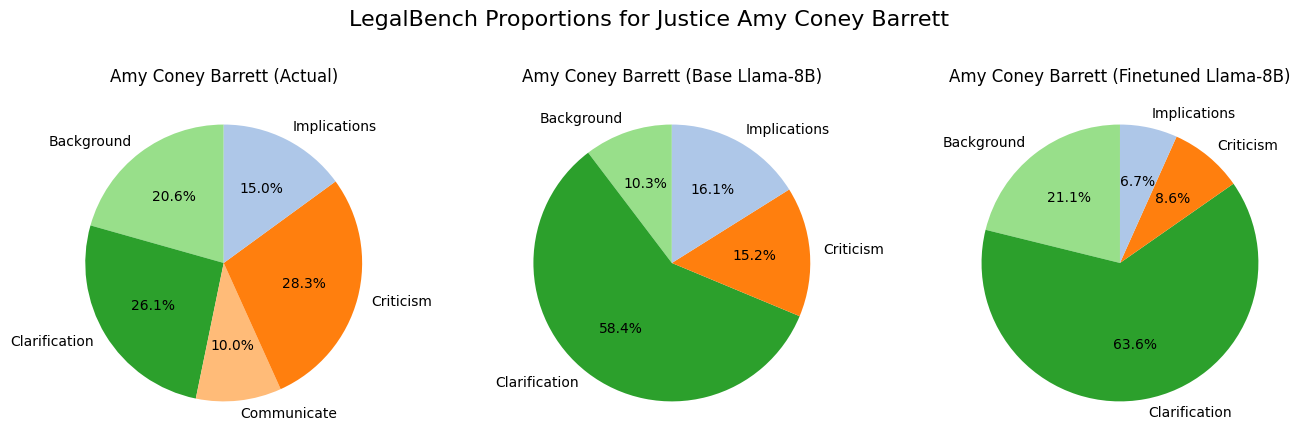

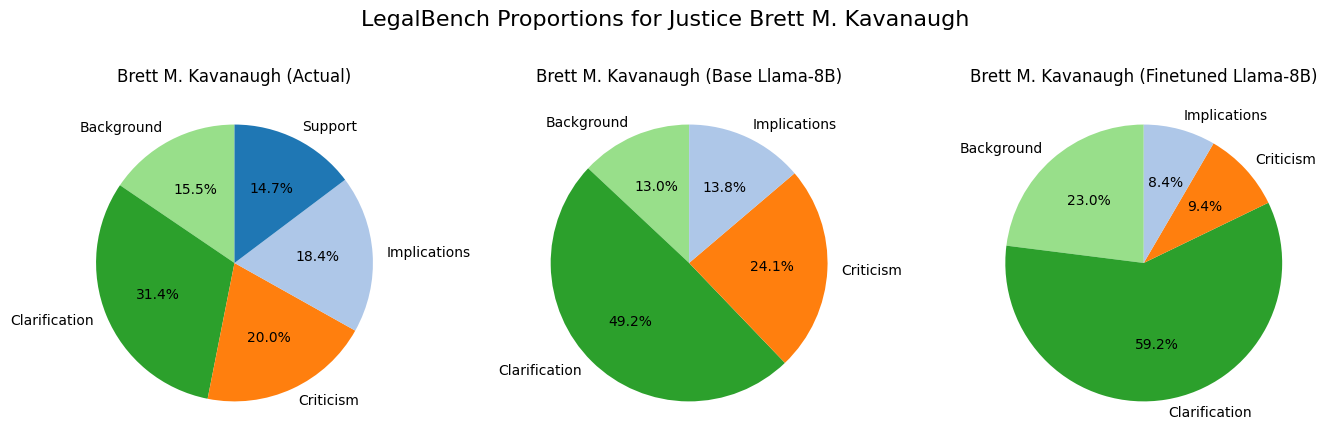

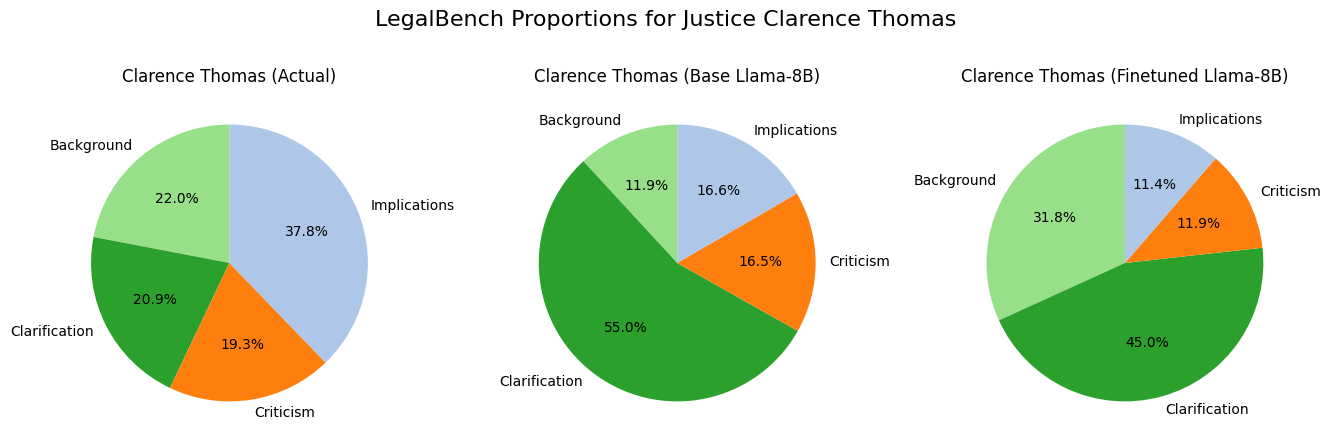

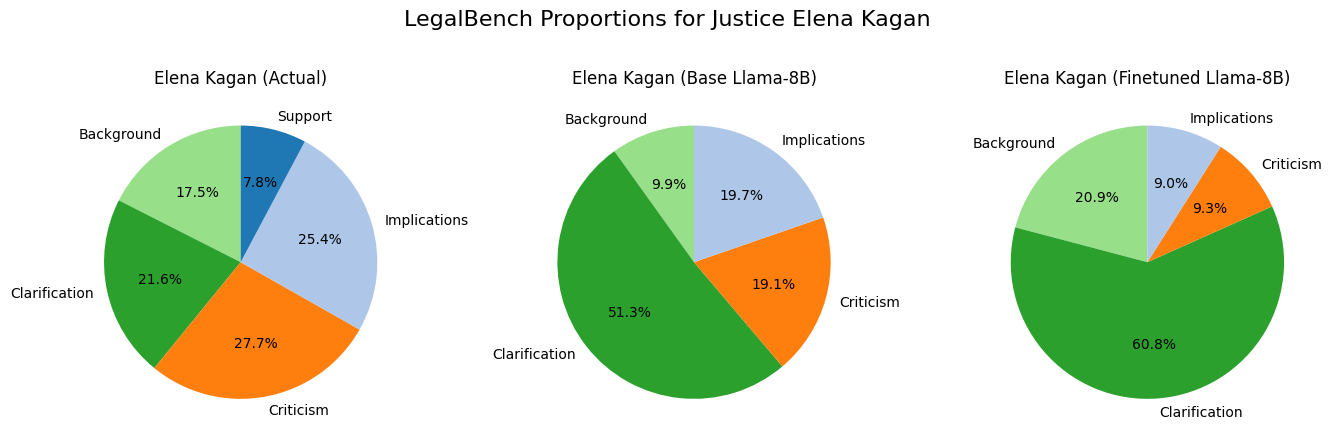

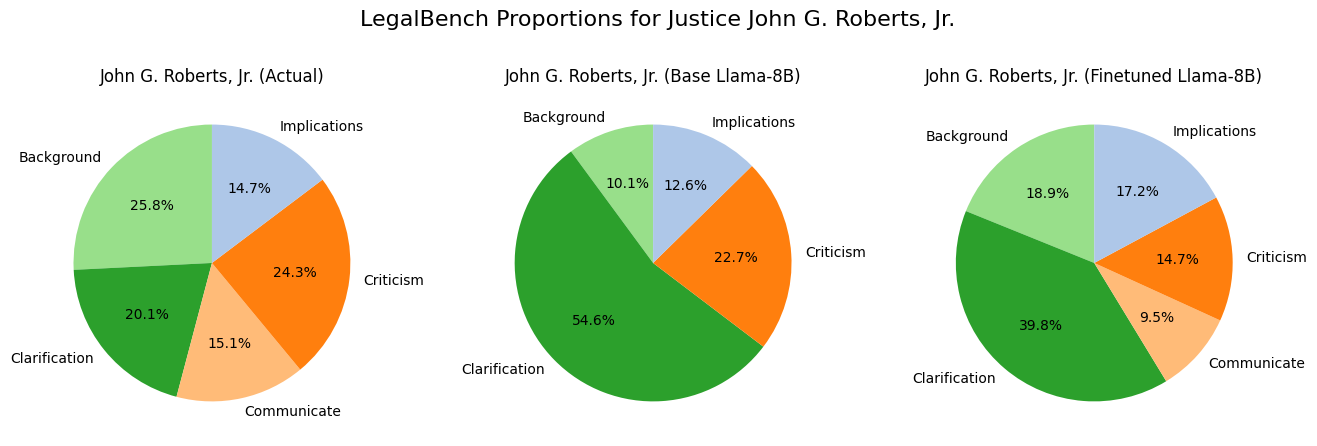

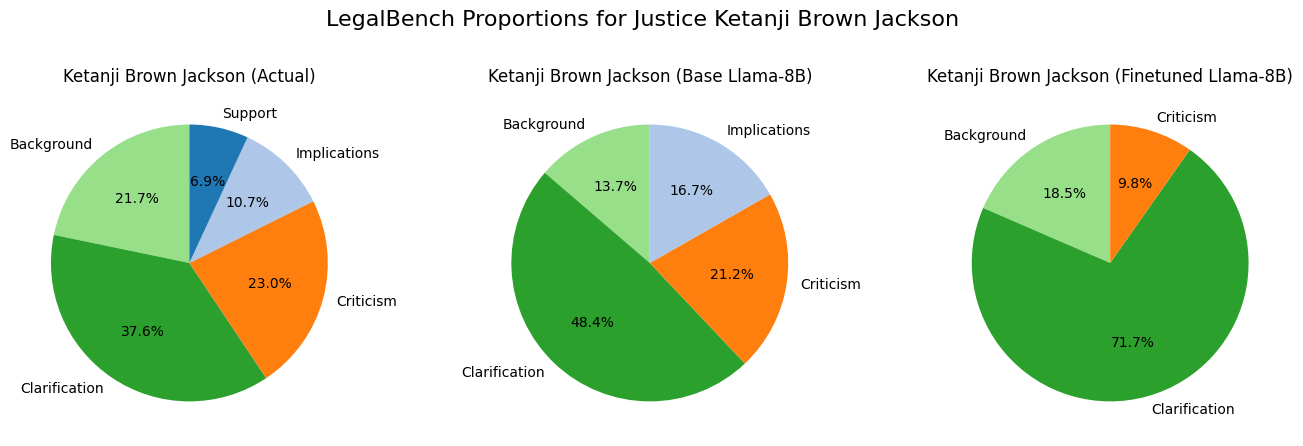

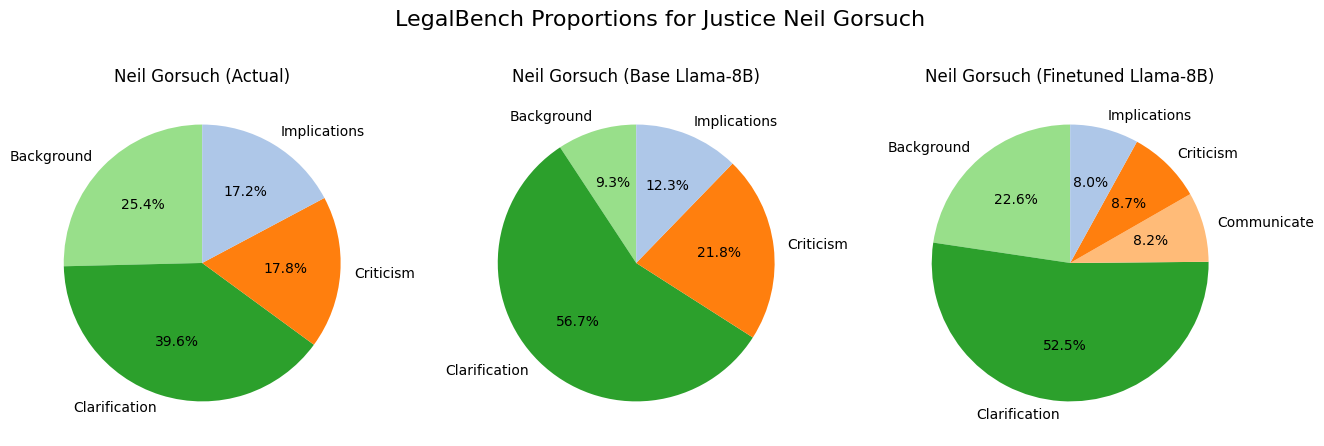

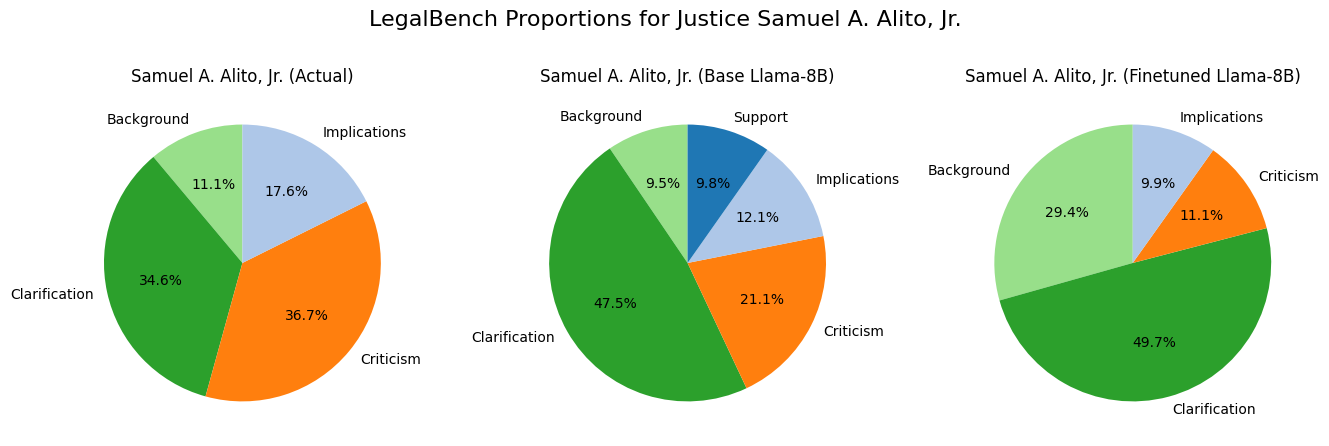

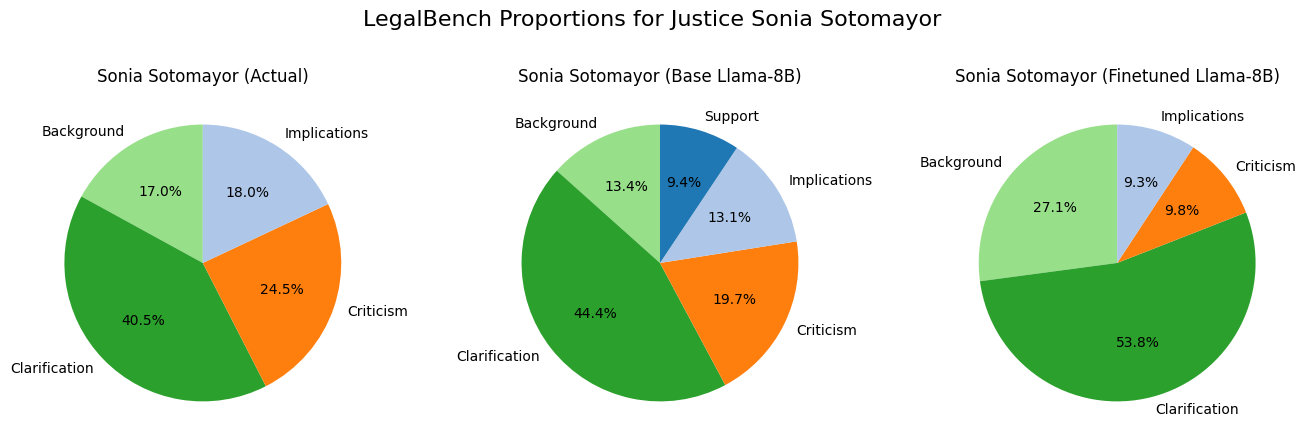

In [26]:
for justice in combined_legalbench_proportions['justice'].unique():
    plot_legalbench_pie_for_justice(mean_proportions_pie, justice)
